In [171]:
from collections import Counter
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

import numpy as np 
import pandas as pd

In [172]:
#Import the Dataset we are working with

In [173]:
data_url = 'https://raw.githubusercontent.com/georgetown-analytics/Formula1/main/data/processed/MasterData5.csv'
data_df = pd.read_csv(data_url, sep = ',', engine = 'python', encoding = 'latin-1')

**Modeling**

In [174]:
data_df.head()

,raceId,driverId,constructorId,grid,familyStatus,Completion Status,year,circuitId,country,alt,...,TAVG,TMAX,TMIN,oneHot_circuits_1,oneHot_circuits_2,oneHot_circuits_3,oneHot_circuits_4,oneHot_circuits_5,oneHot_circuits_6,trackType2
0,1,2,2,9,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
1,1,3,3,5,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
2,1,4,4,10,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
3,1,6,3,11,1,0,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
4,1,7,5,17,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1


In [175]:
data_df.shape

(9258, 26)

In [176]:
data_df.isna().sum()

raceId               0
driverId             0
constructorId        0
grid                 0
familyStatus         0
Completion Status    0
year                 0
circuitId            0
country              0
alt                  0
isHistoric           0
nationality          0
total_lap_time       0
average_lap_time     0
minimum_lap_time     0
PRCP                 0
TAVG                 0
TMAX                 0
TMIN                 0
oneHot_circuits_1    0
oneHot_circuits_2    0
oneHot_circuits_3    0
oneHot_circuits_4    0
oneHot_circuits_5    0
oneHot_circuits_6    0
trackType2           0
dtype: int64

In [177]:
#Position, fastest lap, rank, fastest lap speed all contain nulls. 
#This suggests that they would have high correlation to our target Completion Status. 
#These columns will be excluded from our feature selection. 

In [178]:
data_df = data_df.rename(columns={"Completion Status": "CompletionStatus"})
y = data_df.loc[:, 'CompletionStatus'] #categorical

In [179]:
X = data_df.loc[:, ['trackType2', #categorical
                        'alt', #numeric
                        'grid', #numeric
                        'average_lap_time', #numeric
                        'minimum_lap_time', #numeric
                        'year', #numeric
                        'PRCP', #numeric
                        'TAVG', #numeric
                        'isHistoric', #categorical
                        "oneHot_circuits_1",
                    "oneHot_circuits_2","oneHot_circuits_3","oneHot_circuits_4","oneHot_circuits_5",
                    "oneHot_circuits_6"
                    
                       ]]

/Users/jamesbifulco/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


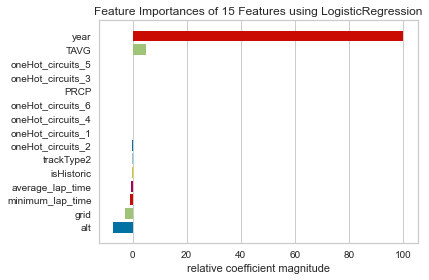

<AxesSubplot:title={'center':'Feature Importances of 15 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [180]:
from yellowbrick.features import FeatureImportances

model = LogisticRegression()
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()

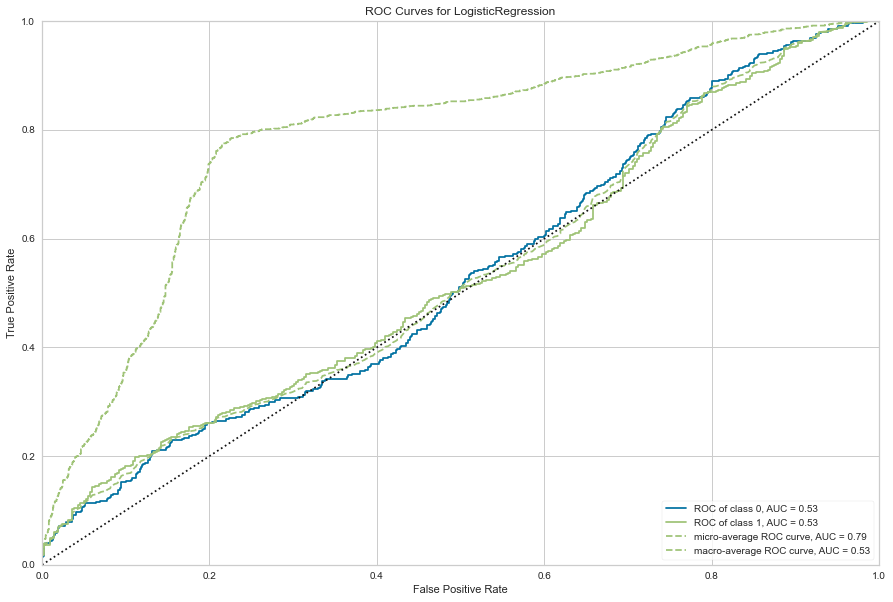

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ROCAUC


# Specify the classes of the target
classes = [0, 1]

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(LogisticRegression(
    multi_class="auto", solver="liblinear"
    ), classes=classes, size=(1080, 720)
)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [182]:
#Test our data on various estimators.

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state = 3)

def score_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
   
    estimator.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    
    # Compute and return F1
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    

# Instantiate the classification models
models = [
    SVC(gamma='auto'), 
    LinearSVC(),  
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), 
    LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_train, y_train, X_test, y_test, model)


SVC: 0.8724505327245053


/Users/jamesbifulco/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC: 0.8727161997563947
KNeighborsClassifier: 0.8625929518267056
LogisticRegression: 0.8729820286323485
LogisticRegressionCV: 0.8735141725083816
BaggingClassifier: 0.8741140735740802
ExtraTreesClassifier: 0.8826259946949602
RandomForestClassifier: 0.8830313014827018


In [183]:
#These models are producing unsually high results. 
#It seems as if there is data leakage taking place. 

In [184]:
data_df.CompletionStatus.value_counts()

1    7108
0    2150
Name: CompletionStatus, dtype: int64

In [185]:
#Data leakage is potentially caused by a class imbalance. 

In [186]:
#Now to use SMOTE to address this issue. 

In [187]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 7108), (1, 7108)]


In [144]:
#Now to test various models on our resampled data

In [188]:
def score_model(X_resampled, y_resampled, X_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """
    # Instantiate the classification model and visualizer
    estimator.fit(X_resampled, y_resampled, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    

models = [
    SVC(gamma='auto'), 
    NuSVC(gamma='auto'), 
    LinearSVC(),  
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), 
    LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_resampled, y_resampled, X_test, y_test, model)

SVC: 1.0
NuSVC: 1.0


/Users/jamesbifulco/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC: 0.8724505327245053
KNeighborsClassifier: 0.8737201365187713
LogisticRegression: 0.6428281186509549
LogisticRegressionCV: 0.6731866340668297
BaggingClassifier: 0.9944095038434662
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0


In [146]:
#Logisitc Regression, LogisticRegressionCV, LinearSVC, KNeighborsClassifier

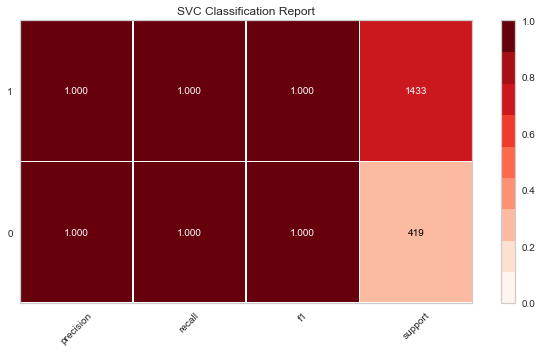

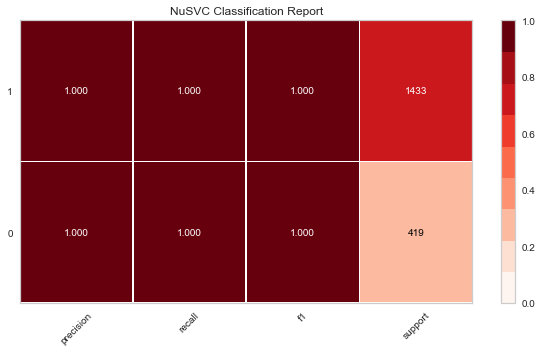

/Users/jamesbifulco/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


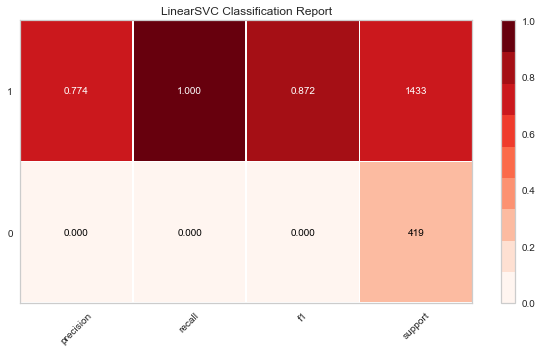

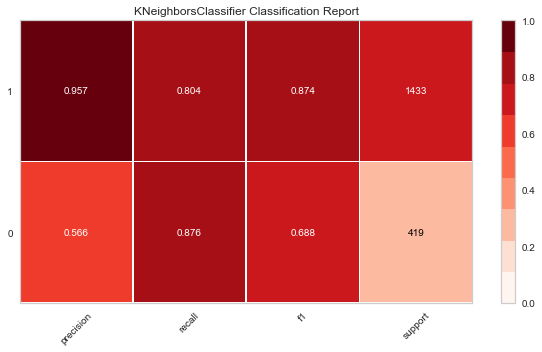

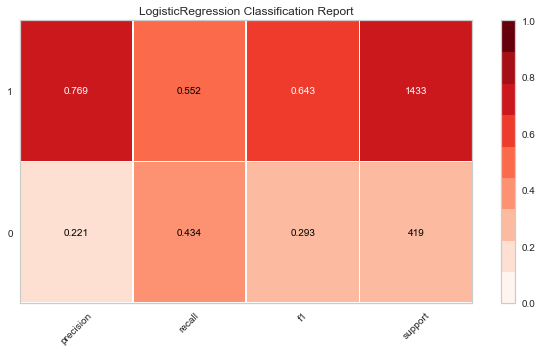

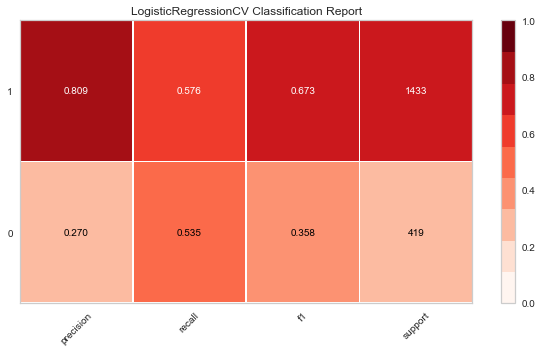

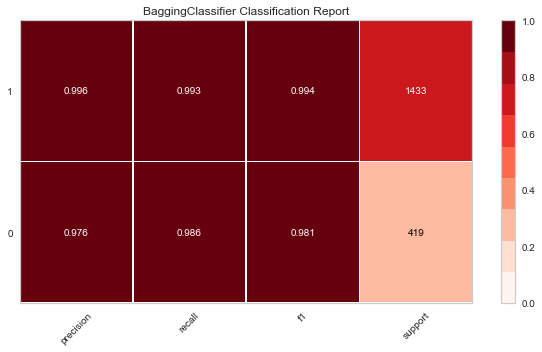

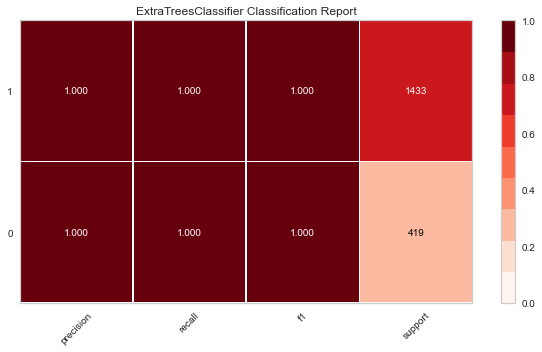

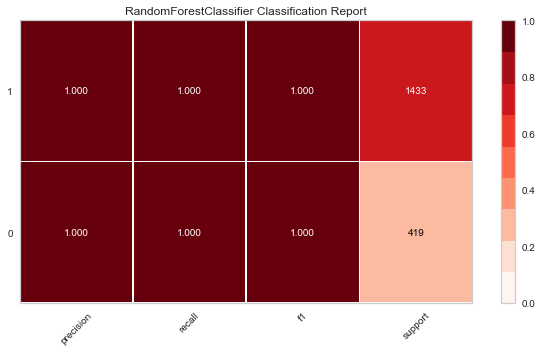

In [189]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator, 
        classes=[0,1], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state = 3)
    X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
    visualizer.fit(X_resampled, y_resampled)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)

In [250]:
#Logisitc Regression, LogisticRegressionCV, LinearSVC, KNeighborsClassifier seem to be our most viable models

# **Evaluating Our Classification Models**

**Logistic Regression**

In [214]:
# train a logistic regression model on the resammpled data 
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_resampled, y_resampled)

LogisticRegression()

In [242]:
y_pred_class = logreg.predict(X_test)

In [243]:
#Classification Accuracy

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.525377969762419


In [218]:
#Null Accuracy - accuracy that could be achieved by always predicting the most frequent class

# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

In [220]:
# calculate the percentage of ones
y_test.mean()

0.7737580993520519

In [221]:
# calculate the percentage of zeros
1 - y_test.mean()

0.22624190064794814

In [222]:
# calculate null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.7737580993520519

In [223]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[182 237]
 [642 791]]


In [224]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [225]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

In [227]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

In [229]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

In [231]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#In this case, when we predict crash, how often are we correct?
#In this case we want to optimize specificity


print(TN / (TN + FP))

In [233]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

In [235]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

In [ ]:
#This logistic regression model performed well on predicting finishes, but we want a model better suited at 
#predicting crashes.
#Now to try our other high performing classifiers and see which one is most specific. 

**Logistic Regression CV**

In [272]:
# train a logistic regression CV model on the resammpled data 
from sklearn.linear_model import LogisticRegressionCV
logregcv = LogisticRegressionCV(cv=3)
logregcv.fit(X_resampled, y_resampled)

LogisticRegressionCV(cv=3)

In [273]:
y_pred_class = logregcv.predict(X_test)

In [274]:
#Classification Accuracy

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.5669546436285097


In [275]:
#Null Accuracy - accuracy that could be achieved by always predicting the most frequent class

# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

1    1433
0     419
Name: CompletionStatus, dtype: int64

In [276]:
# calculate the percentage of ones
y_test.mean()

0.7737580993520519

In [277]:
# calculate the percentage of zeros
1 - y_test.mean()

0.22624190064794814

In [278]:
# calculate null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.7737580993520519

In [279]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[224 195]
 [607 826]]


In [280]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [281]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.5669546436285097
0.5669546436285097


In [282]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.4330453563714903
0.43304535637149033


In [283]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.5764131193300768
0.5764131193300768


In [284]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#In this case, when we predict crash, how often are we correct?
#In this case we want to optimize specificity


print(TN / (TN + FP))

0.5346062052505967


In [285]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

0.46539379474940334


In [286]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.8090107737512243
0.8090107737512243


**Linear SVC**

In [287]:
# train a linear SVC model on the resammpled data 
from sklearn.svm import LinearSVC
linearsvc = LinearSVC()
linearsvc.fit(X_resampled, y_resampled)

/Users/jamesbifulco/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [288]:
y_pred_class = linearsvc.predict(X_test)

In [289]:
#Classification Accuracy

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7737580993520519


In [291]:
#Null Accuracy - accuracy that could be achieved by always predicting the most frequent class

# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

1    1433
0     419
Name: CompletionStatus, dtype: int64

In [292]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[   0  419]
 [   0 1433]]


In [293]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [294]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.7737580993520519
0.7737580993520519


In [295]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.22624190064794816
0.22624190064794814


In [296]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

1.0
1.0


In [297]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#In this case, when we predict crash, how often are we correct?
#In this case we want to optimize specificity


print(TN / (TN + FP))

0.0


In [298]:
#Data Leakage taking place, potentially due to class imbalance.

**KNeighbors Classifier**

In [299]:
# train a KNeighbors Classifier model on the resammpled data 
from sklearn.neighbors import KNeighborsClassifier
knclassifier = KNeighborsClassifier()
knclassifier.fit(X_resampled, y_resampled)

KNeighborsClassifier()

In [300]:
y_pred_class = knclassifier.predict(X_test)

In [301]:
#Classification Accuracy

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8201943844492441


In [302]:
#Null Accuracy - accuracy that could be achieved by always predicting the most frequent class

# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

1    1433
0     419
Name: CompletionStatus, dtype: int64

In [303]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[ 367   52]
 [ 281 1152]]


In [304]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [305]:
#Classification Accuracy: Overall, how often is the classifier correct?

print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.8201943844492441
0.8201943844492441


In [306]:
#Classification Error: Overall, how often is the classifier incorrect?

print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.17980561555075594
0.17980561555075592


In [307]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.8039078855547802
0.8039078855547802


In [308]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#In this case, when we predict crash, how often are we correct?
#In this case we want to optimize specificity


print(TN / (TN + FP))

0.8758949880668258


In [309]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

print(FP / (TN + FP))

0.12410501193317422


In [310]:
#Precision: When a positive value is predicted, how often is the prediction correct?

print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.9568106312292359
0.9568106312292359


**Findings**

- KNeighborsClassifier seems to be our highest performing model. 
- The results are high but seem legitimate as data leakage does not seem to be taking place. 
- Linear SVC should be ignored moving forward as it is prone to data leakage. 
- Logistic Regression and Logistic Regression CV perform okay and capture all of our data. 

**Next Steps**
- Increase threshold for prediciting crashes in order to increase specificity of the model.
- Evaluate ROC/AUC curves of models to choose a threshold that balances sensitivity and specificity in a way that makes sense for predicitng crashes. 
- Create modeling pipelines with appropriate preprocessing techniques to achieve higher performance. 
- Implement relevant hyperparameter tuning techniques to achieve higher model performance. 
- Evaluate features and consider feature reduction. 